In [2]:
# IMPORT LIBRARIES

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch
from scipy.io import loadmat

import eelbrain
from eelbrain import UTS, NDVar
import mne
import re

In [3]:
# CONSTANTS

# Data locations
#BASE_DIR = Path.cwd()
BASE_DIR = Path("~").expanduser() / 'Data' / 'cocoha2' # <---- Uncomment this if you are working with files in data root directory

DATA_PREPROC = BASE_DIR / "data_preprocessed"
PREDICTOR_DIR = BASE_DIR / 'predictors'
TRF_DIR = BASE_DIR / 'TRFs'
PREDICTOR_DIR.mkdir(exist_ok=True)
TRF_DIR.mkdir(exist_ok=True)

STIMULUS_DIR = BASE_DIR / 'stimuli'
EEG_DIR = BASE_DIR / 'eeg'
EEG_DIR.mkdir(exist_ok=True)
SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'S\d+', path.name)]
STIMULI = [stimulus.stem for stimulus in STIMULUS_DIR.glob("*.wav")]


# Constants
LOW_FREQUENCY = 0.5
HIGH_FREQUENCY = 20

# Creating predictors from stimuli

In [4]:
# CREATE PREDICTORS (gammatone envelopes): envelope_log, envelope_onset, and envelope_words

for stimulus in STIMULI:
    # ————————————————————————————————————————————————————————————————————————————————————————————————
    # Define destination
    dst = STIMULUS_DIR / f'{stimulus}-gammatone.pickle'
    
    # Define all output paths
    paths = [
        PREDICTOR_DIR / f'{stimulus}~envelope-log.pickle',
        PREDICTOR_DIR / f'{stimulus}~envelope-onset.pickle',
        PREDICTOR_DIR / f'{stimulus}~envelope-log-8band.pickle',
        PREDICTOR_DIR / f'{stimulus}~envelope-onset-8band.pickle',
    ]
    # Check if all files exist AND are loadable
    for path in paths:
        skip = False
        if path.exists():
            try:
                existing_data = eelbrain.load.unpickle(path)
                if existing_data is not None:
                    skip = True
            except Exception as e:
                print(f"Warning: existing predictor file {path.name} is corrupted or unreadable, will recompute. ({e})")
    if skip:
        #print(f"All predictors for stimulus {stimulus} already exist and are valid, skipping...")
        continue
    #print(f"Processing stimulus {stimulus}")

    # ————————————————————————————————————————————————————————————————————————————————————————————————
    # Load the sound file corresponding to the predictors
    wav = eelbrain.load.wav(STIMULUS_DIR / f'{stimulus}.wav')
    # Apply a filter to make it high resolution
    envelope = eelbrain.gammatone_bank(wav, 80, 15000, 128, location='left', tstep=0.001) 

    # ————————————————————————————————————————————————————————————————————————————————————————————————
    # Make the log envelope, and 8 band frequency version
    envelope_log = (envelope + 1).log()
    envelope_log_sum = envelope_log.sum('frequency')
    envelope_log_8band = envelope_log.bin(nbins=8, func='sum', dim='frequency')
    
    # Make the onset envelope, and 8 band frequency version
    envelope_onset = eelbrain.edge_detector(envelope_log, c=30)
    envelope_onset_sum = envelope_onset.sum('frequency')
    envelope_onset_8band = envelope_onset.bin(nbins=8, func='sum', dim='frequency')
    
    # ————————————————————————————————————————————————————————————————————————————————————————————————
    # Save pickles
    eelbrain.save.pickle(envelope_log_sum, 
                         PREDICTOR_DIR / f'{stimulus}~envelope-log.pickle') # <-- This is referred to as gammatone-1 in document
    eelbrain.save.pickle(envelope_onset_sum, 
                         PREDICTOR_DIR / f'{stimulus}~envelope-onset.pickle') # <-- This is referred to as gammatone-on-1 in document
    eelbrain.save.pickle(envelope_log_8band, 
                         PREDICTOR_DIR / f'{stimulus}~envelope-log-8band.pickle') # <-- This is referred to as gammatone-8 in document
    eelbrain.save.pickle(envelope_onset_8band, 
                         PREDICTOR_DIR / f'{stimulus}~envelope-onset-8band.pickle') # <-- This is referred to as gammatone-on-8 in document
print('Process Finished')

Process Finished


In [5]:
# DATA PROCESSING OF ENVELOPES

SAMPLING_RATE = 1/64
envelopes_log = {}
envelopes_log_8band = {}
envelopes_onset = {}
envelopes_onset_8band = {}

for stimulus in STIMULI:
    # Resample spectrograms to 64 hz, offset and filter (data processing)
    # Log
    envelope_log = eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~envelope-log.pickle')
    envelope_log = envelope_log.bin(SAMPLING_RATE, dim='time', label='start')
    envelope_log = eelbrain.pad(envelope_log, tstart=-0.100, tstop=envelope_log.time.tstop + 1, name='envelope_log')
    envelope_log = eelbrain.filter_data(envelope_log, LOW_FREQUENCY, HIGH_FREQUENCY)
    envelopes_log[stimulus] = envelope_log
    # Log 8 band
    envelope_log_8band = eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~envelope-log-8band.pickle')
    envelope_log_8band = envelope_log_8band.bin(SAMPLING_RATE, dim='time', label='start')
    envelope_log_8band = eelbrain.pad(envelope_log_8band, tstart=-0.100, tstop=envelope_log_8band.time.tstop + 1, name='envelope_log_8band')
    envelope_log_8band = eelbrain.filter_data(envelope_log_8band, LOW_FREQUENCY, HIGH_FREQUENCY)
    envelopes_log_8band[stimulus] = envelope_log_8band
    # Onset
    envelope_onset = eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~envelope-onset.pickle')
    envelope_onset = envelope_onset.bin(SAMPLING_RATE, dim='time', label='start')
    envelope_onset = eelbrain.pad(envelope_onset, tstart=-0.100, tstop=envelope_onset.time.tstop + 1, name='envelope_onset')
    envelope_onset = eelbrain.filter_data(envelope_onset, LOW_FREQUENCY, HIGH_FREQUENCY)
    envelopes_onset[stimulus] = envelope_onset
    # Onset 8 band
    envelope_onset_8band = eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~envelope-onset-8band.pickle')
    envelope_onset_8band = envelope_onset_8band.bin(SAMPLING_RATE, dim='time', label='start')
    envelope_onset_8band = eelbrain.set_time(envelope_onset_8band, envelope_log.time, name='envelope_onset_8band')
    envelope_onset_8band = eelbrain.filter_data(envelope_onset_8band, LOW_FREQUENCY, HIGH_FREQUENCY)
    envelopes_onset_8band[stimulus] = envelope_onset_8band

# Extract the duration of the stimuli, so we can later match the EEG to the stimuli
# durations = [gt.time.tmax for stimulus, gt in zip(STIMULI, envelopes_log)]

# Models
# ------
models = {
    #'envelope_log': [envelopes_log],
    # Compare different scales for the acoustic response
    'envelope_log_8band': envelopes_log_8band,
    # The acoustic edge detection model
    #'envelope_log_onset': [envelopes_log, envelopes_onset],
    #'envelope_onset_8band': [envelopes_onset_8band],
    #'acoustic_8band': [envelopes_log_8band, envelopes_onset_8band],
    # Models with word-onsets and word-class
    #'words': [envelopes_words_onset],
    #'words+lexical': [envelopes_words_onset, envelopes_words_lexical, envelopes_words_nlexical],
    #'acoustic+words': [envelopes_log_8band, envelopes_onset_8band, envelopes_words_onset],
    #'acoustic+words+lexical': [envelopes_log_8band, envelopes_onset_8band, envelopes_words_onset, 
    #                           envelopes_words_lexical, envelopes_words_nlexical],
}
print('Process finished')


Process finished


In [6]:
# LOAD EEG FROM .mat to .fif
for file in DATA_PREPROC.glob("*.mat"):
    SUBJECT = file.stem.split("_")[0]

    dst_dir = EEG_DIR / SUBJECT
    dst_dir.mkdir(exist_ok=True)
    dst = dst_dir / f'{SUBJECT}_raw.fif'
    if dst.exists():
        print(f"File {dst.name} already exists, skipping conversion for subject {SUBJECT}...")
        continue

    # Load the .mat file
    mat = loadmat(file, squeeze_me=True, struct_as_record=False)
    data = mat['data']

    trials = []

    for trial in data.eeg:  # 60 trials
        eeg = trial[:, :64]    # remove extra channels
        trials.append(eeg)
    
    # Concatenate trials along the time axis
    eeg_data = np.concatenate(trials, axis=0).T  # Transpose to shape (n_channels, n_times)

    ch_names = data.dim.chan.eeg[0][:64].tolist()

    info = mne.create_info(ch_names=ch_names, sfreq=64, ch_types='eeg')

    raw = mne.io.RawArray(eeg_data, info)
    raw.set_montage('biosemi64')  # Set the montage to BioSemi 64

    raw.save(dst, overwrite=True)
    

File S5_raw.fif already exists, skipping conversion for subject S5...
File S15_raw.fif already exists, skipping conversion for subject S15...
File S11_raw.fif already exists, skipping conversion for subject S11...
File S1_raw.fif already exists, skipping conversion for subject S1...
File S4_raw.fif already exists, skipping conversion for subject S4...
File S14_raw.fif already exists, skipping conversion for subject S14...
File S10_raw.fif already exists, skipping conversion for subject S10...
File S17_raw.fif already exists, skipping conversion for subject S17...
File S7_raw.fif already exists, skipping conversion for subject S7...
File S18_raw.fif already exists, skipping conversion for subject S18...
File S3_raw.fif already exists, skipping conversion for subject S3...
File S13_raw.fif already exists, skipping conversion for subject S13...
File S8_raw.fif already exists, skipping conversion for subject S8...
File S16_raw.fif already exists, skipping conversion for subject S16...
File

In [7]:
# LOAD EEG DATA

# Create dictionaries to hold the eeg scans of each subject, and the predictors of each model
subject_padded_eegs = {} 
n_trials = 60
sampling_rate = 64

for subject in SUBJECTS:
    # Extract the raw files
    raw = mne.io.read_raw(EEG_DIR / f'{subject}' / f'{subject}_raw.fif', preload=True)
    # Filter the raw data to the desired band
    raw.filter(LOW_FREQUENCY, HIGH_FREQUENCY, n_jobs=1)
    # Interpolate bad channels
    #raw.interpolate_bads() # <-- No bad filters so commented out

    # ————————————————————————————————————————————————————————————————————————————————————————————————
    # load EEG data
    eeg = eelbrain.load.mne.raw_ndvar(raw) # Load the raw data as NDVar 64 sensor, 192000 time
    # EEG comes already concatenated, we must SPLIT, PAD in the right places, and then CONCATENATE back together
    total_samples = eeg.shape[-1] 
    samples_per_trial = total_samples / n_trials
    tstep = eeg.time.tstep
    trial_duration = samples_per_trial * tstep

    # SPLIT by trial duration in seconds
    trials = [eeg.sub(time=(i*trial_duration, (i+1)*trial_duration)) for i in range(n_trials)]
    # PAD each trial relative to trial start
    padded_trials = [eelbrain.pad(trial, tstart=-0.100, tstop=(trial.time.tmax - trial.time.tmin + 1.0)) for trial in trials]
    # Reset time for each trial to start at 0
    n_samples = padded_trials[0].shape[-1] # This should give 3270 samples
    padded_trials = [eelbrain.set_time(trial, UTS(0, 1/sampling_rate, n_samples+1)) for trial in padded_trials]
    # CONCATENATE
    eeg_padded = eelbrain.concatenate(padded_trials)
    
    # Update dictionaries
    subject_padded_eegs[subject] = eeg_padded
    
print('Process finished')


Process finished


In [8]:
# GET PREDICTORS

subject_model_predictors = {}
expinfo_table = eelbrain.load.tsv("../expinfo.csv", encoding='utf-8-sig').as_dataframe()

for subject in SUBJECTS:
    # Update dictionaries
    subject_model_predictors[subject] = {}

    # Get predictors
    for model, predictors in models.items():
        # print(f"Concatenating: {subject} ~ {model} predictors")
        # Select and concetenate the predictors corresponding to the EEG trials
        attended_predictors_concatenated = []
        unattended_predictors_concatenated = []
        predictor_types = {'predictor': predictors}

        for predictor_name, predictor in predictor_types.items():
            attended_trial_predictors = []
            unattended_trial_predictors = []
            
            for _, row in expinfo_table.iterrows():
                if row['n_speakers'] == 1:
                    continue
                if row['attend_mf'] == 1:
                    attended_wavfile = row['wavfile_male']
                    unattended_wavfile = row['wavfile_female']
                else:
                    attended_wavfile = row['wavfile_female']
                    unattended_wavfile = row['wavfile_male']
                    
                attended_wavfile = attended_wavfile.strip("'")
                unattended_wavfile = unattended_wavfile.strip("'")
                
                attended_path_key = attended_wavfile.removesuffix('.wav')
                unattended_path_key = unattended_wavfile.removesuffix('.wav')

                attended_trial_predictors.append(predictor[attended_path_key])
                unattended_trial_predictors.append(predictor[unattended_path_key])
                
            attended_predictors_long = eelbrain.concatenate(attended_trial_predictors)
            unattended_predictors_long = eelbrain.concatenate(unattended_trial_predictors)

            #print(f"  Predictor '{predictor_name}' trials: {len(trial_predictors)}")
            #print(f"  Predictor '{predictor_name}' duration: {predictor_long.time.tstop:.2f}s")
            
            attended_predictors_concatenated.append(attended_predictors_long)
            unattended_predictors_concatenated.append(unattended_predictors_long)
            
        subject_model_predictors[subject][model] = (attended_predictors_long, unattended_predictors_long)
print('Process finished')


Process finished


In [9]:
# SANITY CHECK

# make sure dimensions of eeg match predictors
print(eeg_padded.time)
print(attended_predictors_concatenated[0].time)

UTS(0.0, 0.015625, 196260)
UTS(0.0, 0.015625, 196260)


In [ ]:
# ESTIMATE TRF

for subject in SUBJECTS:
    # ————————————————————————————————————————————————————————————————————————————————————————————————
    # Make save directory
    subject_trf_dir = TRF_DIR / subject
    subject_trf_dir.mkdir(exist_ok=True)
    trf_paths = {model: subject_trf_dir / f'{subject} {model}.pickle' for model in models}
    # Skip this subject if all files already exist
    #if all(path.exists() for path in trf_paths.values()): 
        #continue

    # ————————————————————————————————————————————————————————————————————————————————————————————————
    # Load eeg
    eeg = subject_padded_eegs[subject]
    print('——————————————————————————————')
    print(f'{subject} eeg extracted')

    # ————————————————————————————————————————————————————————————————————————————————————————————————
    # Loop for estimating TRFs
    for model, predictors in models.items():

        attended_trf_path = subject_trf_dir / f'attended_{subject}_{model}.pickle'
        unattended_trf_path = subject_trf_dir / f'unattended_{subject}_{model}.pickle'
        
        # Skip if the file already exists
        skip = False
        if subject_trf_dir.exists():
            try:
                existing_trf_att = eelbrain.load.unpickle(attended_trf_path)
                existing_trf_unatt = eelbrain.load.unpickle(unattended_trf_path)

                if existing_trf_att is not None and existing_trf_unatt is not None:
                    print(f"TRFs for {subject} ~ {model} already exists, skipping...\n")
                    skip = True
            except Exception as e:
                print(f"Warning: existing TRF file for {subject} ~ {model} is corrupted or unreadable, will recompute. ({e})")
        if skip:
            continue
        print(f"Estimating: {subject} ~ {model}")
        
        
        # ————————————————————————————————————————————————————————————————————————————————————————————————
        # Fit the mTRF
        # Each subject model predictor is a tuple of (attended_predictors_long, unattended_predictors_long)
        attended_predictors_long, unattended_predictors_long = subject_model_predictors[subject][model]
        
        print('now boosting attended')
        attended_trf = eelbrain.boosting(eeg_padded, attended_predictors_long, -0.100, 1.000, 
                                error='l1', basis=0.050, partitions=5, test=1, selective_stopping=True)
        
        print('now boosting unattended')
        unattended_trf = eelbrain.boosting(eeg_padded, unattended_predictors_long, -0.100, 1.000, 
                                error='l1', basis=0.050, partitions=5, test=1, selective_stopping=True)

        # ————————————————————————————————————————————————————————————————————————————————————————————————
        
        # save attended and unattended trfs as pickle files with correct path
        eelbrain.save.pickle(attended_trf, attended_trf_path)
        eelbrain.save.pickle(unattended_trf, unattended_trf_path)

        print(f'Attended + unattended TRFs for {model} complete')
        

——————————————————————————————
S5 eeg extracted
TRFs for S5 ~ envelope_log_8band already exists, skipping...

——————————————————————————————
S2 eeg extracted
TRFs for S2 ~ envelope_log_8band already exists, skipping...

——————————————————————————————
S3 eeg extracted
TRFs for S3 ~ envelope_log_8band already exists, skipping...

——————————————————————————————
S4 eeg extracted
TRFs for S4 ~ envelope_log_8band already exists, skipping...

——————————————————————————————
S17 eeg extracted
Estimating: S17 ~ envelope_log_8band
now boosting attended
now boosting unattended
Attended + unattended TRFs for envelope_log_8band complete
——————————————————————————————
S10 eeg extracted
Estimating: S10 ~ envelope_log_8band
now boosting attended
now boosting unattended
Attended + unattended TRFs for envelope_log_8band complete
——————————————————————————————
S11 eeg extracted
Estimating: S11 ~ envelope_log_8band
now boosting attended
now boosting unattended
Attended + unattended TRFs for envelope_log_8b

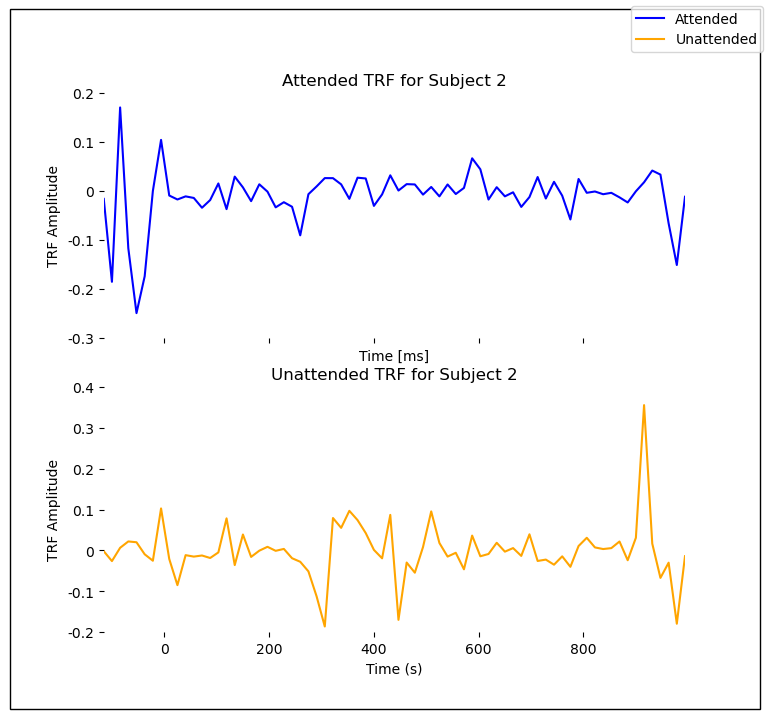

In [11]:
from matplotlib import pyplot

attended_trf = eelbrain.load.unpickle(TRF_DIR / f'S2/attended_S2_envelope_log_8band.pickle')
unattended_trf = eelbrain.load.unpickle(TRF_DIR / f'S2/unattended_S2_envelope_log_8band.pickle')

attended_trf_mean = attended_trf.h_scaled.mean('sensor').mean('frequency')
unattended_trf_mean = unattended_trf.h_scaled.mean('sensor').mean('frequency')

# plot the TRFs together in one plot for the first subject with pyplot
# Setup the figure layout
fig, axes = pyplot.subplots(2, figsize=(7.5, 7), sharex=True, subplot_kw=dict(frame_on=False))
eelbrain.plot.UTS(attended_trf_mean, axes=axes[0], color='blue')
eelbrain.plot.UTS(unattended_trf_mean, axes=axes[1], color='orange')

fig.legend(['Attended', 'Unattended'], loc='upper right')
axes[0].set_title(f'Attended TRF for Subject {2}')
axes[1].set_title(f'Unattended TRF for Subject {2}')
axes[0].set_ylabel('TRF Amplitude')
axes[1].set_ylabel('TRF Amplitude')
axes[1].set_xlabel('Time (s)')


eelbrain.plot.figure_outline()

In [ ]:
# investigate the r values of the attended and unattended models, to see if they are above chance and if attended is higher than unattended

print("attended r value:", attended_trf_mean.)
print("unattended r value:", unattended_trf_mean.r)

AttributeError: 'NDVar' object has no attribute 'r'